# Hurricane Intensity Prediction Model - Regression

### Prediction of Hurricane Rapid Intensification

Project Summary: Storms that undergo rapid intensification (RI) are associated with the highest forecat errors and larger economic losses.
    To reduce the damage caused by the hurricane, accurate prediction of hurricane intensity is critical. This project aims to improve previous models that predict hurricane intensity in 24 hours.
    
Project Goal: Finding a model that effectively predicts hurricane intensity in 24 hours

In [45]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing
import statistics
import time
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from numpy import arange


#Machine Learning Tools
import sklearn # For machine learning library
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import xgboost as xgb


#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss  # Compute the Brier score
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt  #plotting library


#Displaying More Rows
pd.options.display.max_rows = 500

## Importing Data and Data Inspection

Let's take a look closer at each data set. Few of the data characteristics that we are looking for:
- column names
- data type
- number of rows
- missing values (null)
- plausible features that could impact survival rate
- target column

In [46]:
# Set up the location of the data
fname='SHIPS_RII_fcst_ATL_Alicia.csv'
#fname='Dataset_SHIPS_RII_EPAC.csv'

# Read SHIPS data
ships = pd.read_csv(fname)


In [47]:
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

In [48]:
# Function: Counts all null values in each columns
def count_null(data):
    null_each_col={}

    for col in data.columns:
        null_count=data[col].isnull().sum()
        null_each_col[col]=null_count
    return null_each_col

## Parameters Set-up

Setting up RI threshold, train/forecast threshold, target variable/feature, and climatoloogy constant

In [49]:
# Year range for training and validating
year_train=['1998','2008']

# Year range for forecast
year_fcst=['2009','2017']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125   #ATL 30 kt
#clim=0.084   #EPAC 30 kt

## Data Cleaning

- Cleaning Date Column
- Creating Target Column 'TAR'
- Dropping all DELV Columns
- Dropping all null values

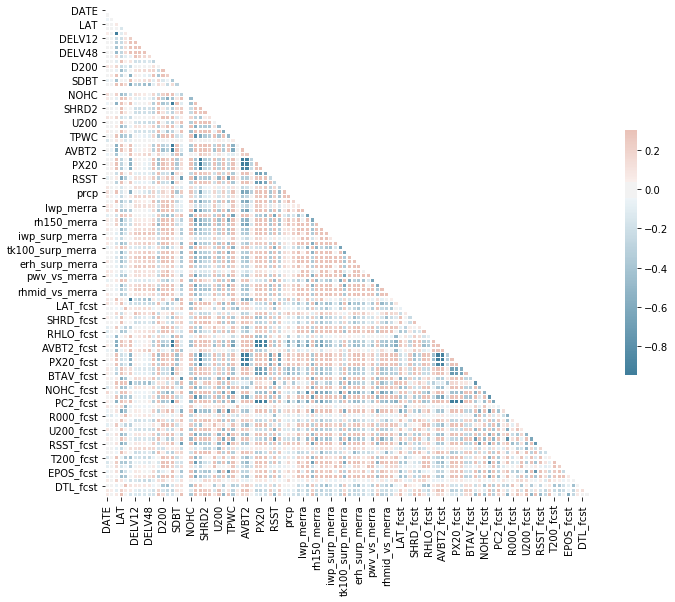

In [50]:
# Compute the correlation matrix

corr = ships.corr()



# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [51]:
# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4]).astype(int)

ships['Wind_Speed_24'] = ships['VMAX']+ships['DELV24']

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))
ships.head()

# Dropping all DELV columns
# - Dropping DELV columns before droping null values saved 1971 data points
ships=ships[['NAME','DATE','HOUR','Wind_Speed_24','DELV24','DELV48','MONTH','VMAX','LAT','LON','PER','SHRD','D200','RHLO','SDBT',
            'POT','PC2','SHRD2','SHRG','DIVC','U200','EPSS','ENSS','TPWC','PC1','SDBT2','TBMX','RSST']]

ships.sort_index()

,NAME,DATE,HOUR,Wind_Speed_24,DELV24,DELV48,MONTH,VMAX,LAT,LON,PER,SHRD,D200,RHLO,SDBT,POT,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,PC1,SDBT2,TBMX,RSST
0,ALBE,820602,12,50.0,30.0,25.0,6,20,21.7,-87.1,NaN,26.4,64,70,NaN,-103,NaN,25.1,29.6,49.0,22.4,5.1,1.6,61.8,NaN,NaN,NaN,28.0
1,ALBE,820602,18,75.0,50.0,15.0,6,25,22.2,-86.5,NaN,19.4,65,68,NaN,-97,NaN,21.6,30.2,45.0,18.7,4.8,2.0,61.9,NaN,NaN,NaN,28.0
2,ALBE,820603,0,65.0,35.0,0.0,6,30,22.6,-85.8,10.0,19.3,84,70,NaN,-87,NaN,18.6,29.8,75.0,16.9,5.2,1.8,61.0,NaN,NaN,NaN,27.8
3,ALBE,820603,6,55.0,15.0,-15.0,6,40,22.8,-85.0,15.0,17.7,70,70,NaN,-75,NaN,22.1,36.2,88.0,17.9,4.8,1.8,60.3,NaN,NaN,NaN,27.6
4,ALBE,820603,12,45.0,-5.0,-25.0,6,50,23.2,-84.2,20.0,17.4,51,66,NaN,-71,NaN,24.3,34.0,60.0,20.9,2.2,2.2,61.5,NaN,NaN,NaN,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11777,RINA,171108,0,45.0,0.0,NaN,11,45,34.6,-48.7,5.0,20.5,29,71,24.3,-37,123.0,25.2,33.1,36.0,22.0,1.3,5.0,42.9,15.0,280.0,15.4,23.5
11778,RINA,171108,6,NaN,NaN,NaN,11,50,36.4,-48.7,10.0,20.8,19,73,14.7,-28,90.0,24.5,32.3,16.0,21.8,1.1,5.4,43.0,15.0,192.0,-17.2,22.9
11779,RINA,171108,12,NaN,NaN,NaN,11,45,38.3,-48.8,0.0,21.2,12,74,13.5,-29,126.0,25.2,33.8,3.0,23.0,0.0,6.7,43.0,15.0,173.0,-3.4,22.7
11780,RINA,171108,18,NaN,NaN,NaN,11,45,40.1,-49.0,-5.0,22.5,14,70,11.5,-14,75.0,29.1,38.9,20.0,28.4,0.0,9.8,44.3,15.0,145.0,-33.0,21.3


In [52]:
null_counts = count_null(ships)
null_counts

{'NAME': 0,
 'DATE': 0,
 'HOUR': 0,
 'Wind_Speed_24': 2122,
 'DELV24': 2122,
 'DELV48': 4035,
 'MONTH': 0,
 'VMAX': 0,
 'LAT': 0,
 'LON': 0,
 'PER': 2225,
 'SHRD': 0,
 'D200': 0,
 'RHLO': 0,
 'SDBT': 1075,
 'POT': 0,
 'PC2': 1656,
 'SHRD2': 0,
 'SHRG': 0,
 'DIVC': 104,
 'U200': 0,
 'EPSS': 0,
 'ENSS': 0,
 'TPWC': 0,
 'PC1': 1656,
 'SDBT2': 1075,
 'TBMX': 1075,
 'RSST': 0}

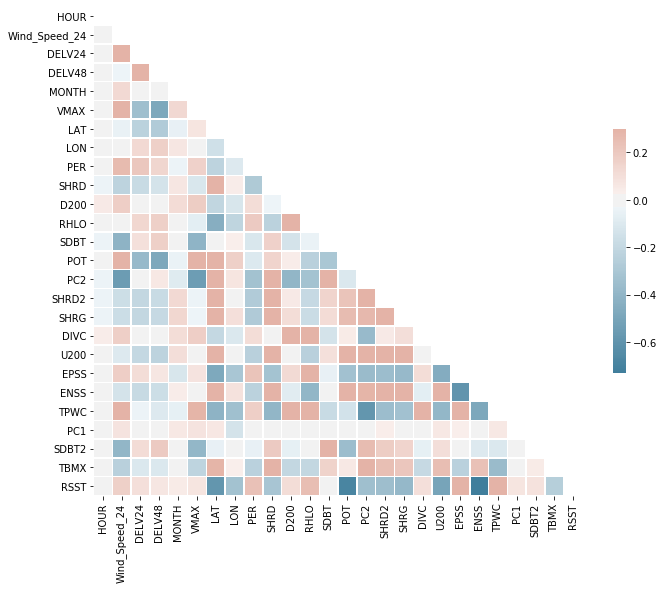

In [53]:
# Compute the correlation matrix

corr = ships.corr()



# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
# Either drop Null Values or replace it with mean value
ships=ships.dropna(subset=['DELV48'])

ships_mean=ships
ships_mean=ships_mean.fillna(ships_mean.mean())

ships_median=ships
ships_median=ships_median.fillna(ships_median.median())

ships=ships.dropna()
ships

,NAME,DATE,HOUR,Wind_Speed_24,DELV24,DELV48,MONTH,VMAX,LAT,LON,PER,SHRD,D200,RHLO,SDBT,POT,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,PC1,SDBT2,TBMX,RSST
72,DEBB,820914,0,65.0,35.0,65.0,9,30,21.5,-71.0,0.0,16.9,26,65,28.6,-110,35.0,17.0,20.8,30.0,5.6,5.4,2.4,58.5,1.0,275.0,0.7,28.8
73,DEBB,820914,6,65.0,35.0,65.0,9,30,22.4,-71.8,0.0,20.7,23,67,28.4,-112,23.0,18.8,23.5,18.0,8.7,4.6,2.5,58.3,0.0,347.0,-30.6,28.7
74,DEBB,820914,12,75.0,40.0,60.0,9,35,23.5,-71.9,5.0,8.7,40,66,30.0,-110,31.0,14.2,18.1,64.0,7.2,4.5,2.5,57.2,1.0,357.0,-39.9,28.8
75,DEBB,820914,18,90.0,35.0,40.0,9,55,24.6,-71.8,25.0,13.3,39,64,19.6,-82,-60.0,11.2,16.9,46.0,8.2,5.9,2.6,58.6,1.0,301.0,-63.5,28.8
76,DEBB,820915,0,95.0,30.0,30.0,9,65,25.6,-71.0,30.0,17.9,53,62,10.7,-74,-83.0,16.2,24.4,71.0,13.0,6.0,2.5,59.3,1.0,207.0,-66.2,28.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11756,OPHE,171013,18,100.0,20.0,0.0,10,80,32.0,-32.5,-10.0,9.7,5,62,12.2,-24,24.0,14.3,17.0,18.0,24.0,0.2,4.1,52.5,0.0,177.0,-22.7,26.0
11770,RINA,171106,6,40.0,10.0,20.0,11,30,29.0,-50.7,0.0,14.8,14,67,29.4,-94,118.0,24.0,30.0,9.0,18.0,1.6,4.0,45.7,15.0,241.0,-24.6,26.2
11771,RINA,171106,12,40.0,10.0,15.0,11,30,29.1,-50.4,0.0,14.3,5,66,26.2,-93,126.0,23.4,29.9,3.0,16.2,1.0,4.1,46.6,15.0,277.0,-15.8,26.1
11772,RINA,171106,18,40.0,10.0,15.0,11,30,29.4,-50.2,0.0,18.8,3,65,24.5,-90,138.0,24.6,30.7,8.0,18.0,1.1,4.1,46.0,15.0,257.0,8.5,25.9


In [55]:
null_counts = count_null(ships)
null_counts

{'NAME': 0,
 'DATE': 0,
 'HOUR': 0,
 'Wind_Speed_24': 0,
 'DELV24': 0,
 'DELV48': 0,
 'MONTH': 0,
 'VMAX': 0,
 'LAT': 0,
 'LON': 0,
 'PER': 0,
 'SHRD': 0,
 'D200': 0,
 'RHLO': 0,
 'SDBT': 0,
 'POT': 0,
 'PC2': 0,
 'SHRD2': 0,
 'SHRG': 0,
 'DIVC': 0,
 'U200': 0,
 'EPSS': 0,
 'ENSS': 0,
 'TPWC': 0,
 'PC1': 0,
 'SDBT2': 0,
 'TBMX': 0,
 'RSST': 0}

## Creating Grids for Data Sets, Sampling Methods, and Hyperparameters

- Predictor Sets: Sets with different predictor features
- Data Sets:      Data Sets with different sampling methods
- Model Sets:     Different types of models 

In [56]:
#Predictor Sets

Predictor_Sets=[]

# Adding different features into the list
Predictor_Sets.append(('Set1', ['MONTH','VMAX','LAT','LON','PER','SHRD','D200','RHLO','SDBT',
            'POT','PC2','SHRD2','SHRG','DIVC','U200','EPSS','ENSS','TPWC','PC1','SDBT2','TBMX','RSST']))
# Predictor_Sets.append(('Set2', ['VMAX','LAT','PER','SHRD','D200','RHLO','SDBT',
#             'POT','PC2','SHRD2','SHRG','DIVC','U200','ENSS','TPWC','PC1','SDBT2','TBMX']))
#Dropped EPSS, Month, RSST

# Predictor_Sets.append(('Set3', ['PER','SHRD','D200','TPW','SDBT','POT','OHC','VMX0','prcp_surp']))
# Predictor_Sets.append(('Kaplan 2015', ['PER','SHRD','D200','RHLO','PX30','SDBT','POT','OHC','prcp_surp']))
# Predictor_Sets.append(('Kaplan 2015 Imp', ['PER','SHRD','D200','TPWC','PC2','SDBT','POT'])) #ICDA didn't exist in the dataset
# Predictor_Sets.append(('Kaplan 2015 Imp V2', ['MONTH','LAT','VMAX','PER','SHRD','D200','TPWC','PC2','SDBT','POT'])) #ICDA didn't exist in the dataset

In [57]:
# This function normalizes the provided data and desired column names

def normalization(data,column_names):
    data_nur=data[column_names]
    data_nur=(data_nur-data_nur.mean())/(data_nur.std()) #standard normal distribution
    data[column_names]=data_nur[column_names]
    return data


In [58]:
# Normalized and Non-Normalized Data Sets

Range_Sets=[]

num_col=['MONTH','VMAX','LAT','PER','SHRD','D200','RHLO','SDBT',
            'POT','PC2','SHRD2','SHRG','DIVC','U200','EPSS','ENSS','TPWC','PC1','SDBT2','TBMX','RSST']
ships_nor=normalization(ships,num_col)
ships_mean_nor=normalization(ships_mean,num_col)
ships_median_nor=normalization(ships_median,num_col)

# Adding created data set into a series
# Range_Sets.append(('Normalized', ships_nor))
# Range_Sets.append(('Not Normalized', ships))
# Range_Sets.append(('Normalized Mean', ships_mean_nor))
Range_Sets.append(('Not Normalized Mean', ships_mean))
# Range_Sets.append(('Normalized Median', ships_median_nor))
# Range_Sets.append(('Not Normalized Median', ships_median))


In [59]:
ships

,NAME,DATE,HOUR,Wind_Speed_24,DELV24,DELV48,MONTH,VMAX,LAT,LON,PER,SHRD,D200,RHLO,SDBT,POT,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,PC1,SDBT2,TBMX,RSST
72,DEBB,820914,0,65.0,35.0,65.0,0.199687,-1.147752,-0.147441,-71.0,-0.387994,0.329994,-0.237087,-0.497815,1.906801,-1.261106,0.567344,0.163099,-0.186255,-0.126542,0.160643,0.815849,-0.381624,-0.062854,-1.277117,0.926230,1.271738,0.562570
73,DEBB,820914,6,65.0,35.0,65.0,0.199687,-1.147752,-0.020961,-71.8,-0.387994,0.775050,-0.313030,-0.224851,1.877537,-1.321742,0.436240,0.373840,0.115248,-0.416980,0.423360,0.426043,-0.318140,-0.092003,-1.372392,1.961332,0.241344,0.489948
74,DEBB,820914,12,75.0,40.0,60.0,0.199687,-0.968986,0.133626,-71.9,0.153880,-0.630390,0.117314,-0.361333,2.111645,-1.261106,0.523643,-0.164719,-0.487758,0.696368,0.296239,0.377318,-0.318140,-0.252324,-1.277117,2.105096,-0.064811,0.562570
75,DEBB,820914,18,90.0,35.0,40.0,0.199687,-0.253923,0.288213,-71.8,2.321375,-0.091638,0.092000,-0.634297,0.589943,-0.412195,-0.470562,-0.515952,-0.621759,0.260710,0.380986,1.059477,-0.254657,-0.048280,-1.277117,1.300017,-0.841722,0.562570
76,DEBB,820915,0,95.0,30.0,30.0,0.199687,0.103608,0.428746,-71.0,2.863248,0.447114,0.446401,-0.907260,-0.712283,-0.169649,-0.721845,0.069437,0.215749,0.865790,0.787774,1.108203,-0.318140,0.053742,-1.277117,-0.051367,-0.930606,0.635192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11756,OPHE,171013,18,100.0,20.0,0.0,1.057606,0.639906,1.328160,-32.5,-1.471741,-0.513270,-0.768688,-0.907260,-0.492807,1.346263,0.447166,-0.153011,-0.610592,-0.416980,1.719997,-1.717886,0.697592,-0.937328,-1.372392,-0.482659,0.501412,-1.470841
11770,RINA,171106,6,40.0,10.0,20.0,1.915525,-1.147752,0.906560,-50.7,-0.387994,0.084042,-0.540859,-0.224851,2.023855,-0.776014,1.474147,0.982645,0.841088,-0.634809,1.211512,-1.035726,0.634108,-1.928398,0.056730,0.437432,0.438864,-1.325597
11771,RINA,171106,12,40.0,10.0,15.0,1.915525,-1.147752,0.920613,-50.4,-0.387994,0.025482,-0.768688,-0.361333,1.555639,-0.745696,1.561550,0.912398,0.829921,-0.780028,1.058966,-1.328080,0.697592,-1.797227,0.056730,0.954983,0.728559,-1.398219
11772,RINA,171106,18,40.0,10.0,15.0,1.915525,-1.147752,0.962773,-50.2,-0.387994,0.552522,-0.819317,-0.497815,1.306899,-0.654741,1.692654,1.052891,0.919256,-0.659012,1.211512,-1.279355,0.697592,-1.884674,0.056730,0.667454,1.528514,-1.543462


In [60]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)



In [61]:
#================================
# Create ensemble model
#================================
import operator
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin

class EnsembleRegressor(BaseEstimator, RegressorMixin):
    """
    Ensemble classifier for scikit-learn estimators.
    Parameters
    ----------
    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.
    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights
    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.
        Parameters
        ----------
        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels
        """
        for clf in self.clfs:
            clf.fit(X, y)
    def predict(self, X):
        """
        Parameters
        ----------
        X : numpy array, shape = [n_samples, n_features]
        Returns
        ----------
        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """
        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_reg(X)
#             maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])
        return avg
    def predict_reg(self, X):
        """
        Parameters
        ----------
        X : numpy array, shape = [n_samples, n_features]
        Returns
        ----------
        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.
        """
        self.reg = [clf.predict(X) for clf in self.clfs]
        avg = np.average(self.reg, axis=0, weights=self.weights)
        return avg

In [62]:
# Creating a list of models

models = {
#     'Linear_Regression': LinearRegression(),
#     'K_Neighbors': KNeighborsRegressor(),
#     'Decision_Tree': DecisionTreeRegressor(),
#     'Random_Forest_1':RandomForestRegressor(),
    'Random_Forest_2':RandomForestRegressor(),
#     'XGB':xgb.XGBRegressor(),
#     'Neural_Network':MLPRegressor(),
#     'Ridge':Ridge()
}


# Creating Stacking Classifier and Ensemble Using some of the models
estimators1 = [
    ('K_Neighbors', KNeighborsRegressor(n_neighbors=20)),
    ('Decision_Tree', DecisionTreeRegressor(random_state=1,min_samples_split=10,max_depth=20)),
    ('Random_Forest', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=66, max_depth=20, min_samples_leaf=4)),
    ('Linear_Regression',LinearRegression())
]

estimators2 = [
    ('K_Neighbors', KNeighborsRegressor(n_neighbors=18)),
    ('Decision_Tree', DecisionTreeRegressor(random_state=1,min_samples_split=10,max_depth=5))    
]

weights1=[0.1,0.2,0.5,0.2]
# weights2=[0.1,0.2,0.2,0.5]

# models['Stacking Regressor']=StackingRegressor(estimators=estimators1, final_estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=66, max_depth=6, min_samples_leaf=2))
# models['Ensemble Regressor']=EnsembleRegressor(clfs=[ estimators1[0][1], estimators1[1][1], estimators1[2][1],estimators1[3][1]], weights=weights1)
# models['Ensemble Classifier2']=EnsembleClassifier(clfs=[ estimators2[0][1], estimators2[1][1], estimators2[2][1], estimators2[3][1] ], weights=weights2)

# Number of trees in random forest
n_estimators = [125,175]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,6,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid


# Setting parameters for the models
params = {
    'Linear_Regression': {},
    'K_Neighbors': { 'n_neighbors': [10, 18, 30]},
    'Decision_Tree': { 'min_samples_split': [5, 10, 15], 'max_depth':[5,10, 15, 20]},
    'Random_Forest_1': { 'n_estimators': n_estimators,
               'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
#                'bootstrap': bootstrap
                     },
    'Random_Forest_2': {'n_estimators':[150]},
    'XGB': {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]},
#     'Stacking Regressor': {}
    'Ensemble Regressor': {},
#     'Neural_Network': {'random_state':[1], 'max_iter':[500]}
    'Neural_Network': {'hidden_layer_sizes': [(10,30,10),(20,)],'activation': ['tanh', 'relu'],
                                'solver': ['sgd', 'adam','logistic','relu'],'alpha': [0.0001, 0.05],
                                'learning_rate': ['constant','adaptive']},
    'Ridge': {'alpha':[0.5,0.6,0.8,1]}
}



In [63]:
arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [64]:
model_keys=models.keys()

for key in model_keys:
    model=models[key]
    param=params[key]

In [65]:
model

RandomForestRegressor()

In [66]:
null_counts = count_null(ships)
null_counts

{'NAME': 0,
 'DATE': 0,
 'HOUR': 0,
 'Wind_Speed_24': 0,
 'DELV24': 0,
 'DELV48': 0,
 'MONTH': 0,
 'VMAX': 0,
 'LAT': 0,
 'LON': 0,
 'PER': 0,
 'SHRD': 0,
 'D200': 0,
 'RHLO': 0,
 'SDBT': 0,
 'POT': 0,
 'PC2': 0,
 'SHRD2': 0,
 'SHRG': 0,
 'DIVC': 0,
 'U200': 0,
 'EPSS': 0,
 'ENSS': 0,
 'TPWC': 0,
 'PC1': 0,
 'SDBT2': 0,
 'TBMX': 0,
 'RSST': 0}

## Machine Learning Calculator

ML_Calc function takes in predictor,data, and model sets to predict the given target variable of the forecast data

In [67]:
def ML_Calc(predictors,range_sets,models,params,target):
    start_time = time.time()

    results=pd.DataFrame()
    grid_searches = {}

#     data_output=pd.DataFrame(index=ships.index)
#     i=1
    for name_pred,features in predictors:
        print(name_pred)
        for name_range,df_ships in range_sets:            
            df_features = df_ships[features]
            df_target = df_ships['Wind_Speed_24']
            

            for key in model_keys:
                rms=[]

                for train_index, fcst_index in kfold.split(df_features,df_target):

                    df_train_feature, df_train_target = df_features.iloc[train_index], df_target.iloc[train_index]
                    df_fcst_feature, df_fcst_target = df_features.iloc[fcst_index], df_target.iloc[fcst_index]




                    print("Running GridSearchCV for %s" % key)

                    model=models[key]
                    param=params[key]
                    if model == 'Stacking Regressor' or model == 'Ensemble Regressor':
                        model.fit(df_train_feature,df_train_target)
                        prediction_fcst = model.predict(df_fcst_feature)
                        best_param = 'N/A'

                    else:
                        gs = GridSearchCV(model, param, cv=10, verbose=0, n_jobs=-1, refit=True)
                        gs.fit(df_train_feature,df_train_target)
                        grid_searches[key] = gs
                        prediction_fcst = gs.predict(df_fcst_feature)
                        best_param = gs.best_params_



#                         data_one_model=pd.DataFrame(index=fcst_index)
#                         data_one_model[i]=prediction_fcst
#                         data_output = data_output.merge(data_one_model, how='outer', left_index=True, right_index=True)

                    rms.append(sqrt(mean_squared_error(df_fcst_target, prediction_fcst)))

                    



                rms_avg=statistics.mean(rms)
                
#                 importances = gs.feature_importances_

                results=results.append({"Predictor Set":name_pred,"Normalized?":name_range, 
                                        "ML Name":key,"RMS Error":rms_avg,"Param":best_param}, 
                                       ignore_index = True)

    


    results=results[["Normalized?","Predictor Set","ML Name","RMS Error","Param"]]
    end_time = time.time()
    elapsed_time=end_time-start_time
    print(elapsed_time)
    return results


In [74]:
Result=ML_Calc(Predictor_Sets,Range_Sets,models,params,'DELV24')

Set1
Running GridSearchCV for Random_Forest_2
Running GridSearchCV for Random_Forest_2
Running GridSearchCV for Random_Forest_2
Running GridSearchCV for Random_Forest_2
Running GridSearchCV for Random_Forest_2
237.14918971061707


In [75]:
Result.sort_values('RMS Error')

,Normalized?,Predictor Set,ML Name,RMS Error,Param
0,Not Normalized Mean,Set1,Random_Forest_2,11.837336,{'n_estimators': 150}


In [70]:
Predictor_Sets

[('Set1',
  ['MONTH',
   'VMAX',
   'LAT',
   'LON',
   'PER',
   'SHRD',
   'D200',
   'RHLO',
   'SDBT',
   'POT',
   'PC2',
   'SHRD2',
   'SHRG',
   'DIVC',
   'U200',
   'EPSS',
   'ENSS',
   'TPWC',
   'PC1',
   'SDBT2',
   'TBMX',
   'RSST'])]

In [71]:
Result.to_csv(r'C:\Users\kwonk\Guided Project\RMDS_Hurricane_Forecasting\data\aa.csv')

In [72]:
Result['Param']

0    {'n_estimators': 150}
Name: Param, dtype: object